In [1]:
RUNNING_LOCALLY = True

In [2]:
import os

# PLEASE SET YOUR OWN WORKING_DIRECTORY WHEN RUNNING LOCALLY
WORKING_DIRECTORY = "../working_dir" # "/home/yash/Desktop/Courses/CS2470/Final_Project/working_dir/"

if not RUNNING_LOCALLY:
    os.chdir("/home/yash/")
    print("Current Directory ->", os.getcwd())

    WORKING_DIRECTORY = "/home/yash/working_dir/"

    # Ensure that you are working in the right environment
    !echo $CONDA_PREFIX

LOG_FILE = WORKING_DIRECTORY + "log_file.txt"

def write_to_log(statement, include_blank_line=False):
    try:
        with open(LOG_FILE, "a") as myfile:
            if include_blank_line:
                myfile.write("\n\n" + statement)
            else:
                myfile.write("\n" + statement)
    except:
        # Running this locally may cause errors, and isn't required
        pass

In [3]:
import gym
import time
import numpy as np
from collections import deque
from gym import spaces
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Wrappers and set up Environment

In [31]:
class ConcatObs(gym.Wrapper):
    def __init__(self, env, k=4):
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = \
            spaces.Box(low=0, high=255, shape=((k,) + shp), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)

        return self._get_ob()

    def step(self, action):
        
#         ob, reward, done, info = self.env.step(action)
#         self.frames.append(ob)
#         return self._get_ob(), reward, done, info
        total_reward = 0.0
        done = None
        for i in range(self.k):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            self.frames.append(obs)
            
            # only count one live each episode
            done = True if info['lives'] < 4 else False
            if done:  
                break
        return self._get_ob(), total_reward, done, info

    def _get_ob(self):
        return np.array(self.frames)

In [32]:
# A bunch of wrappers to get us started, please use these
class ObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env, GRAYSCALE=False, NORMALIZE=False):
        self.GRAYSCALE = GRAYSCALE
        self.NORMALIZE = NORMALIZE
        super().__init__(env)
    
    def observation(self, obs):
        # Normalise observation by 255
        if self.NORMALIZE:
            obs = obs / 255.0
            
        if self.GRAYSCALE:
            obs = tf.image.rgb_to_grayscale(obs)
                    
        image = obs[:,2:-9,8:,:]
        image = tf.image.resize(image,[84,84])
        image = tf.transpose(tf.reshape(image, image.shape[:-1]),perm = [1,2,0])
        return image

class RewardWrapper(gym.RewardWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def reward(self, reward):
        # Clip reward between 0 to 1
        #return np.clip(reward, 0, 1)
        return reward
    
class ActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def action(self, action):
        return action

In [33]:
env = gym.make("ALE/Riverraid-v5")

In [34]:
# Using the wrappers for the environment
env = ObservationWrapper(RewardWrapper(ActionWrapper(ConcatObs(env,k=4))), GRAYSCALE=True, NORMALIZE=True)
obs = env.reset()

In [116]:
#visualization
#image = tf.keras.preprocessing.image.array_to_img(tf.reshape(image[:,:,3],[84,84,1]))
# image1 = tf.image.resize(obs_,[84,84])
# tf.keras.preprocessing.image.array_to_img(image1)

## DQN

In [35]:
hidden_size = 512
num_actions = env.action_space.n
# q_net = tf.keras.Sequential()
# q_net.add(tf.keras.layers.Flatten())
# q_net.add(tf.keras.layers.Dense(hidden_size, activation='relu'))
# q_net.add(tf.keras.layers.Dense(num_actions, activation='softmax'))
#we can try to add convolutional layers

def create_q_model(input_shape, hidden_size, num_actions):
    # Network defined by the Deepmind paper
    inputs = layers.Input(shape=input_shape)
    # Convolutions on the frames on the screen

    CNN1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    CNN2 = layers.Conv2D(64, 4, strides=2, activation="relu")(CNN1)
    CNN3 = layers.Conv2D(64, 3, strides=1, activation="relu")(CNN2)
    flatten = layers.Flatten()(CNN3)
    Dense1 = tf.keras.layers.Dense(hidden_size, activation='relu')(flatten) 
    out = tf.keras.layers.Dense(num_actions, activation='softmax')(Dense1)

    return keras.Model(inputs=inputs, outputs=out)

q_net = create_q_model(input_shape=obs.shape, hidden_size=hidden_size, num_actions=num_actions)
print(q_net.summary())

trainer = tf.keras.optimizers.SGD(learning_rate = 0.01)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 84, 84, 4)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 32)        8224      
                                                                 
 conv2d_4 (Conv2D)           (None, 9, 9, 64)          32832     
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1606144   
                                                                 
 dense_3 (Dense)             (None, 18)                9234

**One episode**

In [71]:
def choose_action(env, q_values, state, epsilon, greedy=False):
    if not greedy and np.random.rand(1) < epsilon:
        #action = env.action_space.sample()
        action = np.random.randint(num_actions)
    else:
        action = tf.math.argmax(q_values, axis=1).numpy()[0] # greedy
    return action


def train_one_episode(q_net, e, gamma, num_steps):
    start_time = time.time()
    rTot = 0
    obs = env.reset()
    step = 0
#     def MSE_loss(q_values, q_values_nst)
        
    for step in range(num_steps):
        with tf.GradientTape() as tape:
            q_values = q_net(np.array([obs]))
            action = choose_action(env, q_values, obs, e)
            # apply the action
    
            nst_obs, reward, done, info = env.step(action)
            done = True if info['lives'] < 4 else False
            q_values_next = q_net(np.array([nst_obs]))
            # action_nst = choose_action(env, q_values_nest, nst_obs, e, greedy=True)
            
            
            ## calculate loss
            action_q = tf.reduce_sum(q_values * tf.one_hot(action, num_actions), axis=1)
        
            nst_q = tf.reduce_sum(tf.one_hot(tf.argmax(q_values, axis=1), num_actions) * q_values_next, axis=1)
            action_target_q = reward + (1 - tf.cast(done, tf.float32)) * gamma * nst_q

            td_error = action_target_q - action_q
            ## huber
            # loss = tf.reduce_mean(tf.where(tf.abs(td_error) < 0.5, tf.square(td_error), tf.abs(td_error) - 0.25))
            loss = tf.reduce_sum(tf.square(td_error))
            
        grad = tape.gradient(loss,q_net.trainable_variables)
        trainer.apply_gradients(zip(grad,q_net.trainable_variables))
        rTot += reward

        obs = nst_obs
        if done:
            break
 
    end_time = time.time()
    inter = end_time-start_time
    return rTot, inter, step

In [72]:
print(train_one_episode(q_net, e, gamma, num_steps))

(90.0, 0.6713769435882568, 17)


**Episodes with n_game**

In [321]:
# Write to log
model_name = "DQN_" + str(n_games)
write_to_log("Starting " + model_name, include_blank_line=True)

In [73]:
# Hyper parameters
num_steps = 100000
gamma = 0.99
decreasing_factor = 0.999
e = 0.99
e_threshold = 0.1

In [74]:
# Train num_games episodes
n_games = 100 #when running in the GCP, we can set a much higher value

rot_list = np.zeros(n_games)
time_list = np.zeros(n_games)
step_each_epi = np.zeros(n_games)

for i in range(n_games):
    if (i+1)%10 == 0:
        print(f'Running game {i+1}/{n_games}...')
        write_to_log(f'Running game {i+1}/{n_games}...', include_blank_line=False)
    
    e = max(e*decreasing_factor, e_threshold)
    
    rot_list[i], time_list[i], step_each_epi[i] = train_one_episode(q_net, e, gamma, num_steps)

env.close()

Running game 10/100...
Running game 20/100...
Running game 30/100...
Running game 40/100...
Running game 50/100...
Running game 60/100...
Running game 70/100...
Running game 80/100...
Running game 90/100...
Running game 100/100...


average_reward:103.9
average_time:0.7579445695877075
max_steps:59.0


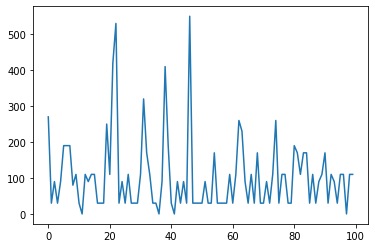

In [75]:
# 100 episodes
print("average_reward:{}".format(sum(rot_list)/n_games))
print("average_time:{}".format(sum(time_list)/n_games))
print("max_steps:{}".format(max(step_each_epi)))
import matplotlib.pyplot as plt
plt.plot(rot_list)

average_reward:264.18
average_time:1.4415897443294525
max_steps:161.0


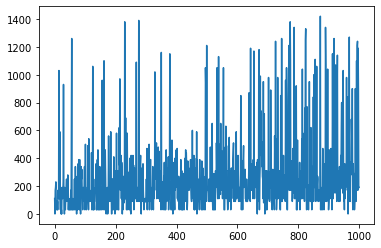

In [29]:
# 1000 episodes results

## Save the model

In [ ]:
write_to_log("Completed " + model_name, include_blank_line=False)
write_to_log("average_reward:{}".format(sum(rot_list)/n_games), include_blank_line=False)
write_to_log("average_time:{}".format(sum(time_list)/n_games), include_blank_line=False)

1. Yingfei - After 100 games:<br>
   average_reward:773.95<br>
   average_time:21.668797335624696<br>
   sum(rot_list[-5:])/5 = 1534.6 (wrong result)
   sum(time_list[-5:])/5 = 15.960728788375855 (wrong result)

In [172]:
model_path = WORKING_DIRECTORY + "model/cDQN_" + str(n_games)
q_net.save(model_path)
q_net_copy = keras.models.load_model(model_path)
# q_net_copy.get_weights()

INFO:tensorflow:Assets written to: model/cDQN_100\assets


In [ ]:
# obs = env.reset()
# rTot = 0
# start_time = time.time()

# for step in range(num_steps):

#     with tf.GradientTape() as tape:
#         # Compute the Q values and best action for the current state
#         q_values = q_net(np.array([obs]))

#         # Epsilon adaptive
#         if np.random.rand(1) < e:
#             action = env.action_space.sample()
#         else:
#             # Added an else statement so the command only runs if necessary
#             action = tf.math.argmax(q_values,axis=1).numpy()[0]

#         # apply the action
#         nst_obs, reward, done, _ = env.step(action)


#         q_values_nst = q_net(np.array([nst_obs]))
#         action_nst = tf.math.argmax(q_values_nst,axis=1).numpy()[0]

#         td_error = q_values.numpy()
#         td_error[0][action] = reward + gamma*np.max(q_values_nst)
#         loss = tf.reduce_sum(tf.square(td_error-q_values))

#     grad = tape.gradient(loss,q_net.trainable_variables)
#     trainer.apply_gradients(zip(grad,q_net.trainable_variables))
#     rTot += reward

#     obs = nst_obs

#     if done:
#         break

# end_time = time.time()
# inter = end_time-start_time